# Accessing ERA5 data

In [134]:
#!pip install xarray dask cartopy cdsapi netCDF4
# Python Standard Libraries
import os
import datetime as dt
import calendar
from string import ascii_lowercase as ABC

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from dask.diagnostics.progress import ProgressBar
from mpl_toolkits.basemap import Basemap

# Climate Data Store API for retrieving climate data
import cdsapi

#### Downloading the Data

First, we'll load ERA5 data from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. To do this, provide your CDS API key.

In [135]:
URL = 'https://cds.climate.copernicus.eu/api/'
KEY = 'b52ba451-e477-4fee-9be1-48c364f8ded4' # add your key here the format should be as {uid}:{api-key}

New to CDS? Consider reading the [CDS tutorial](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html) for a detailed guide.


In [137]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc'}

In [139]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

2025-02-07 08:59:36,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-07 08:59:36,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-07 08:59:36,374 INFO Request ID is 14df5522-4235-4bfe-8e95-02b137fad30e
2025-02-07 08:59:36,503 INFO status has been updated to accepted
2025-02-07 08:59:45,120 INFO status has been updated to successful


'data/era5/temperature_era5.nc'

In [140]:
data = xr.open_dataset('temperature_era5.nc')
data

<xarray.Dataset> Size: 7GB
Dimensions:     (valid_time: 876, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 14kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 4GB ...
    lsm         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [141]:
lat = data.latitude
lon = data.longitude
longitude= data.longitude-180
data = data.sortby(longitude)

temp_2m = data.t2m[0,:,:]


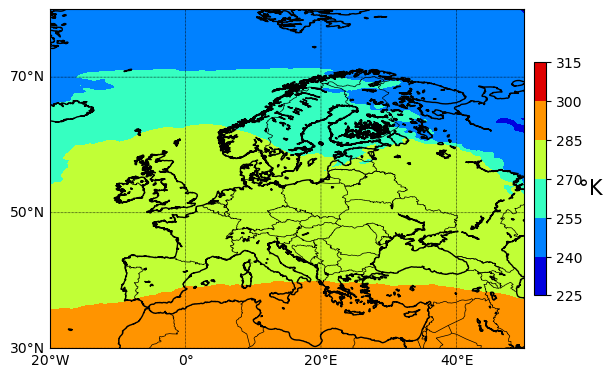

In [142]:
m = Basemap(projection='cyl', llcrnrlon=-20, llcrnrlat=30, urcrnrlon=50, urcrnrlat=80,resolution='i')
m.drawcoastlines(1)
m.drawcountries()

parallels = np.arange(-90,90+0.25,20)
m.drawparallels(parallels, labels=[1,0,0,0], linewidth=0.5)
meridians = np.arange(-180,180+0.25,20)
m.drawmeridians(meridians, labels=[0,0,0,1], linewidth=0.5)

cf = plt.contourf(longitude, lat, temp_2m, cmap='jet')
cb = plt.colorbar(cf, fraction=0.0235, pad=0.02)
cb.set_label(' \u00b0K', fontsize=15, rotation=0)

plt.show()